In [1]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

In [53]:
import mne
# cropping the signal before sci calculation
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    # check if coordinates of the channels
    
    
    #print(raw_intensity.ch_names)

    
    # Get event timings
    #print("Extracting event timings...")
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    #print(f"Original duration: {original_duration:.2f} seconds")
    
    # Cropping dataset
    #print("Cropping the dataset...")
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    #print(f"Cropped duration: {cropped_duration:.2f} seconds")
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    

    
    # Remove break annotations
    print("Removing break annotations for the orginal raw...")
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    print("Removing break annotations for the cropped raw...")
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    
    #downsampling the signal
    #raw_intensity_cropped.resample(3)
    
    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped,  h_freq=1.35)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.7))
    
    if len(bad_channels) > 35:
        print(f"Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None, None, None, None
    
    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels
    
    print(f"Bad channels: {raw_od.info['bads']}")
    # print the number of bad channels
    print(f"Number of bad channels: {len(raw_od.info['bads'])}")
    
     # Get short channels
    short_chs = get_short_channels(raw_od)
    
    # Interpolate only long channels
    long_chs = [ch for ch in raw_od.ch_names if ch not in short_chs.ch_names]
    raw_od.interpolate_bads(reset_bads=True, mode='accurate', method='nearest', exclude=short_chs.ch_names)
    
    
    
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)
    
    if short_chs:
        print(f"Applying short-channel regression. Found {len(short_chs)} short channels.")
        raw_od_corrected = short_channel_regression(raw_od)
    else:
        print("No short channels found. Skipping short-channel regression.")
        raw_od_corrected = raw_od   
        
    # short-channel regression subtracts a scaled version of the signal obtained from the nearest short channel from the signal obtained from the long channel. 

    raw_haemo = beer_lambert_law(raw_od_corrected, ppf=0.1)
    
   
    
    
    """ raw_haemo = raw_haemo.filter(
    l_freq=0.01, h_freq=0.7, method="fir", fir_design="firwin", verbose=False,
    h_trans_bandwidth=0.3, l_trans_bandwidth=0.005) """
    
    # filter
    raw_haemo = raw_haemo.filter(l_freq=0.02, h_freq=0.4, method="fir", fir_design="firwin", verbose=False,)
    
    #raw_haemo.plot_psd(average=True, show=True)

    
    
    

    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-1,
        tmax=15,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=False,
    )

    return raw_haemo, epochs, event_dict, raw_od

In [54]:
all_evokeds = defaultdict(list)
bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)

for sub in range(1,2):  # Loop over subjects
#for sub in subject_list:  # Loop over subjects
    for ses in range(2, 3):  
        bids_path = BIDSPath(
            subject=f"{sub:02d}",
            #subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od = individual_analysis(bids_path)
        
        if raw_haemo is None:
            #print(f"⚠️ Not enough channels left for Subject {sub}, Session {ses:02d}. Skipping...")
            print(f"⚠️ Not enough channels left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            continue

        # Check if epochs contain data
        print(f"Subject {sub:02d}, Session {ses:02d}: {len(epochs)} epochs left")
        #print(f"Subject {sub}, Session {ses:02d}: {len(epochs)} epochs left")

        if len(epochs) < 10:
            print(f"⚠️ Not enough epochs left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            #print(f"⚠️ Not enough epochs left for Subject {sub}, Session {ses:02d}. Skipping...")
            # plot the raw_haemo data
            #raw_haemo.plot(n_channels=30, duration=300, show=True)
            
            continue  # Skip this subject/session
        
        """ for condition in [ "Speech"]:
            if condition in event_dict:
                epochs[condition].plot(event_id=event_dict) """

        # Save individual-evoked participant data
        for condition in epochs.event_id:
            all_evokeds[condition].append(epochs[condition].average())


Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S2_D13 785', 'S2_D13 830', 'S7_D8 785', 'S7_D8 830', 'S8_D7 785', 'S8_D7 830', 'S8_D17 785', 'S8_D17 830', 'S10_D18 785', 'S10_D18 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 12
Applying short-channel regression. Found 8283 short channels.
Subject 01, Session 02: 27 epochs left


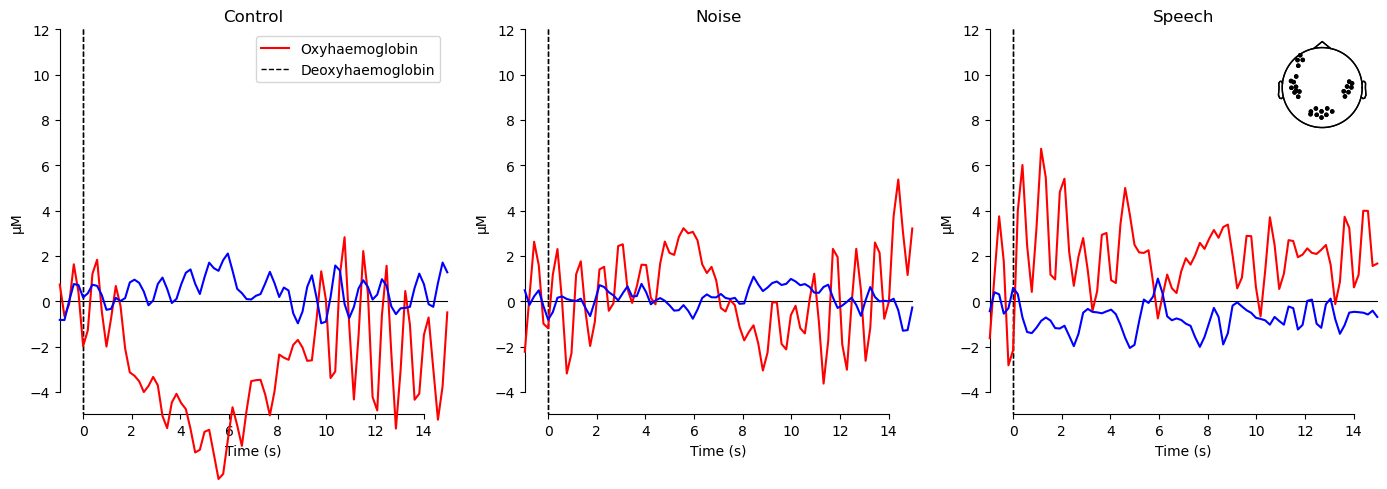

In [55]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds(
            {evoked: all_evokeds[evoked]},
            combine="mean",
            picks=pick,
            axes=axes[idx],
            show=False,
            colors=[color],
            legend=False,
            ylim=lims,
            ci=0.95,
            show_sensors=idx == 2,
        )
        axes[idx].set_title(f"{evoked}")
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

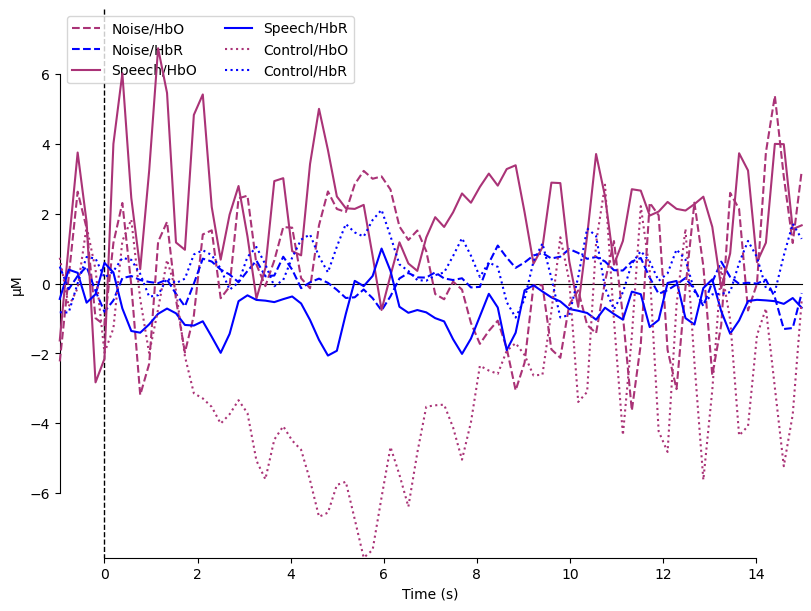

[<Figure size 800x600 with 1 Axes>]

In [56]:
import mne

evoked_dict = {'Noise/HbO': epochs['Noise'].average(picks='hbo'),
                'Noise/HbR': epochs['Noise'].average(picks='hbr'),
                'Speech/HbO': epochs['Speech'].average(picks='hbo'),
                'Speech/HbR': epochs['Speech'].average(picks='hbr'),
                'Control/HbO': epochs['Control'].average(picks='hbo'),
                'Control/HbR': epochs['Control'].average(picks='hbr')} 

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])
    
color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dotted'), Noise=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict,show=True)
                                
                                

In [57]:
from pprint import pprint

def filter_existing_pairs(raw_haemo, pairs):
    """Filter out SD pairs that are no longer present in raw_haemo."""
    valid_pairs = []
    for pair in pairs:
        try:
            # Check if the pair exists in raw_haemo
            idx = picks_pair_to_idx(raw_haemo, [pair])
            if idx:  # If valid index is returned, keep the pair
                valid_pairs.append(pair)
        except Exception:
            pass  # Ignore pairs that cause errors (likely removed)

    return valid_pairs

# Define ROI channel pairs
left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]]
front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]]

# Filter out missing SD pairs
left = filter_existing_pairs(raw_haemo, left)
right = filter_existing_pairs(raw_haemo, right)
back = filter_existing_pairs(raw_haemo, back)
front = filter_existing_pairs(raw_haemo, front)

# Generate indices for remaining pairs
rois = dict(
    Left_Hemisphere=picks_pair_to_idx(raw_haemo, left),
    Right_Hemisphere=picks_pair_to_idx(raw_haemo, right),
    Back=picks_pair_to_idx(raw_haemo, back),
    Front=picks_pair_to_idx(raw_haemo, front),
)

# Print the final valid SD pairs per ROI
print("\nFinal valid SD pairs per ROI:")
pprint({
    "Left_Hemisphere": left,
    "Right_Hemisphere": right,
    "Back": back,
    "Front": front
})

# Print the valid indices per ROI
print("\nFinal ROI indices:")
pprint(rois)



Final valid SD pairs per ROI:
{'Back': [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]],
 'Front': [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]],
 'Left_Hemisphere': [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]],
 'Right_Hemisphere': [[10, 9],
                      [10, 10],
                      [10, 11],
                      [10, 12],
                      [11, 11],
                      [11, 12]]}

Final ROI indices:
{'Back': [np.int64(26),
          np.int64(27),
          np.int64(28),
          np.int64(29),
          np.int64(32),
          np.int64(33),
          np.int64(34),
          np.int64(35),
          np.int64(36),
          np.int64(37),
          np.int64(38),
          np.int64(39),
          np.int64(40),
          np.int64(41),
          np.int64(44),
          np.int64(45)],
 'Front': [np.int64(0),
           np.int64(1),
           np.int64(2),
           np.int64(3),
           np.int64(6),
           np.int64(7),
           np.int64(8),
      

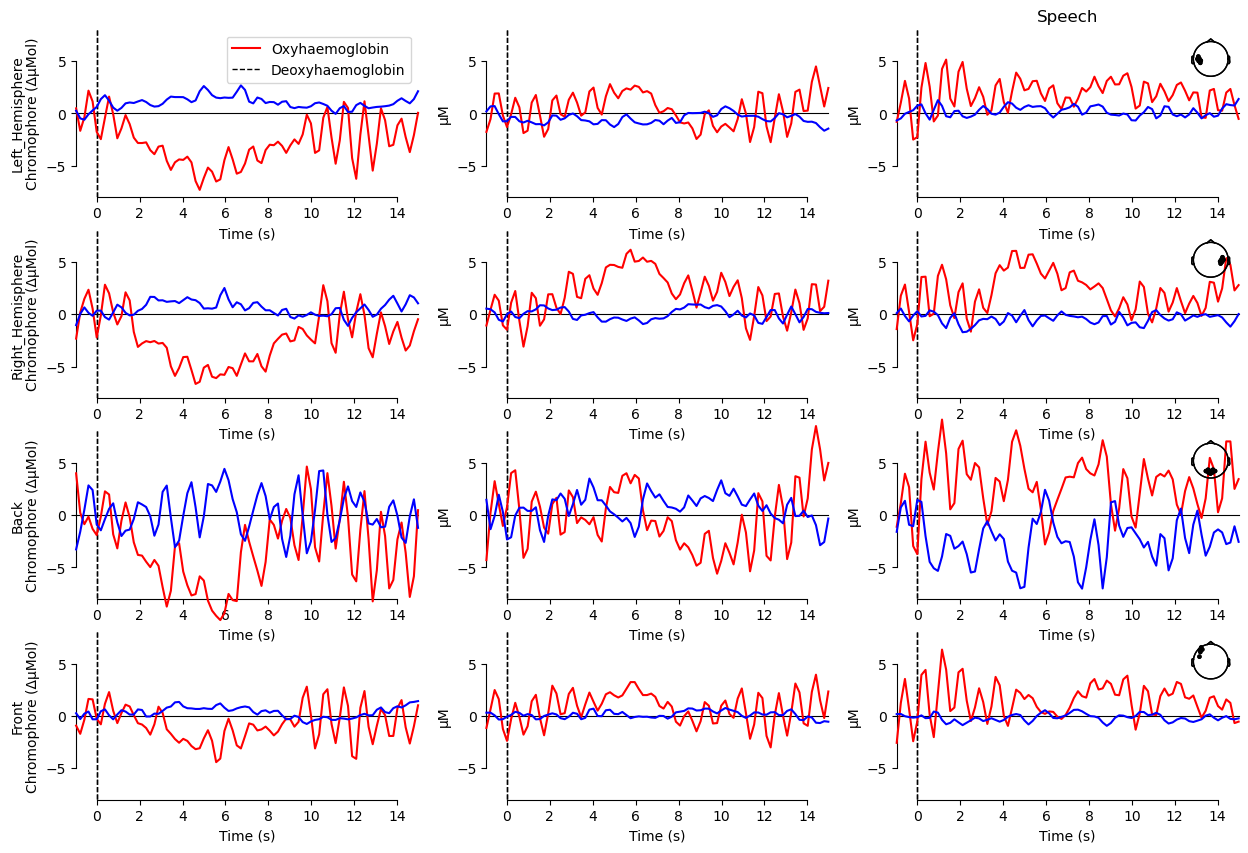

In [58]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds), figsize=(15, 10))
lims = dict(hbo=[-8, 8], hbr=[-8, 8])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == "hbr":
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds(
                {evoked: all_evokeds[evoked]},
                combine="mean",
                picks=picks,
                axes=axes[ridx, cidx],
                show=False,
                colors=[color],
                legend=False,
                ylim=lims,
                ci=0.95,
                show_sensors=cidx == 2,
            )
            axes[ridx, cidx].set_title("")
        axes[0, cidx].set_title(f"{evoked}")
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

# show the figure

plt.show()